In [1]:
import numpy as np
import matplotlib.pyplot as plt
import RWPT_fxns as PTfxn
import os

In [2]:
# %matplotlib inline
# from IPython.display import display, Math, Latex
# import matplotlib.font_manager
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Computer Modern Roman"]})
import gif

In [3]:
make_gif = True

In [4]:
params = PTfxn.get_params()
velVec = PTfxn.get_v0()
XVec = PTfxn.get_X0()
tSeries_vel = PTfxn.init_tSeries()
tSeries_vel = PTfxn.interval_save(velVec, 0, tSeries_vel)
tSeries_X = PTfxn.init_tSeries()
tSeries_X = PTfxn.interval_save(XVec, 0, tSeries_X)

In [5]:
N_current = 0
# save some work by doing the last emission step manually
# e.g., in the case that emit_steps does not evenly divide N
for i in range(params.emit_steps - 1):
  # add the packet of particles
  N_current += params.emitNum
  # update the velocity
  velVec[0 : N_current, :] += PTfxn.dVel_func(velVec[0 : N_current, :], Np=N_current)
  velVec = PTfxn.apply_BC(velVec)
# all particles are now active--update N_current just in case
N_current = params.N
for i in np.arange(params.emit_steps - 1, params.nSteps):
  velVec += PTfxn.dVel_func(velVec)
  velVec = PTfxn.apply_BC(velVec)
  XVec = PTfxn.advect_tracer(XVec, velVec)
  tSeries_vel = PTfxn.interval_save(velVec, i, tSeries_vel)
  tSeries_X = PTfxn.interval_save(XVec, i, tSeries_X)
tSeries_vel = PTfxn.interval_save(velVec, i + 1, tSeries_vel)
tSeries_X = PTfxn.interval_save(XVec, i + 1, tSeries_X)

In [6]:
end_vmax = np.max(velVec, 0)
end_vmin = np.min(velVec, 0)

print(f'max values = {end_vmax}')
print(f'min values = {end_vmin}')

for i in range(params.dim):
  if end_vmax[i] > params.Omega[1, i] or end_vmin[i] < params.Omega[0, i]:
    print(f'ERROR: velocities finished outside of valid domain')

max values = [0.99503087 0.99980002]
min values = [0.00118084 0.00176835]


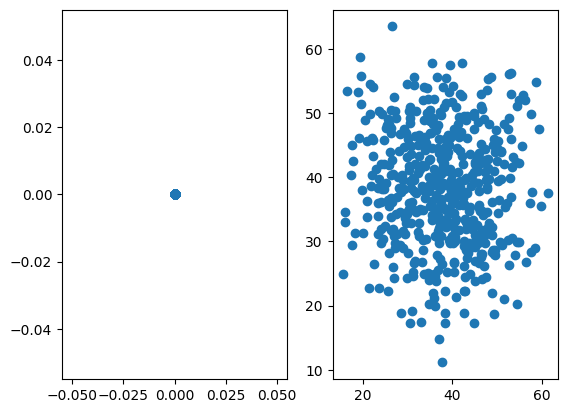

In [7]:
frame = 0
fig, ax = plt.subplots(1, 2)
ax[0].scatter(tSeries_X[:, 0, frame], tSeries_X[:, 1, frame])
frame = -1
ax[1].scatter(tSeries_X[:, 0, frame], tSeries_X[:, 1, frame])

In [8]:
gif_name = 'simple_tracerRW.gif'

if make_gif:
  if os.path.exists(gif_name):
    os.remove(gif_name)

  images = []

  axlimX = [np.min(tSeries_X[:, 0, 0]), np.max(tSeries_X[:, 0, -1])]
  axlimY = [np.min(tSeries_X[:, 1, 0]), np.max(tSeries_X[:, 1, -1])]

  @gif.frame
  def plotter(X):
    plt.scatter(X[:, 0], X[:, 1])
    ax = plt.gca()
    ax.set_xlim(axlimX)
    ax.set_ylim(axlimY)
    ax.text(0.5, 0.8, f'time = {frame * params.saveInterval} of {params.maxT}',
            horizontalalignment='center', verticalalignment='center',
            transform=ax.transAxes)


  for frame in range(0, params.nSaveSteps):
      images.append(plotter(tSeries_X[:, :, frame]))
  gif.save(images, gif_name, duration=100)